
#  Training with customdataset 1

In [2]:
# Imports
import pathlib
import torch

import albumentations
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from skimage.transform import resize
from customdatasets import SegmentationDataSet1
from transformations import (
    ComposeDouble,
    AlbuSeg2d,
    FunctionWrapperDouble,
    normalize_01,
    create_dense_target,
)
from unet import UNet
from trainer import Trainer


# root directory
root = pathlib.Path.cwd() / "Carvana"


def get_filenames_of_path(path: pathlib.Path, ext: str = "*"):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [file for file in path.glob(ext) if file.is_file()]
    return filenames


# input and target files
inputs = get_filenames_of_path(root / "Input")
targets = get_filenames_of_path(root / "Target")

# training transformations and augmentations
transforms_training = ComposeDouble(
    [
        FunctionWrapperDouble(
            resize, input=True, target=False, output_shape=(128, 128, 3)
        ),
        FunctionWrapperDouble(
            resize,
            input=False,
            target=True,
            output_shape=(128, 128),
            order=0,
            anti_aliasing=False,
            preserve_range=True,
        ),
        AlbuSeg2d(albumentations.HorizontalFlip(p=0.5)),
        FunctionWrapperDouble(create_dense_target, input=False, target=True),
        FunctionWrapperDouble(
            np.moveaxis, input=True, target=False, source=-1, destination=0
        ),
        FunctionWrapperDouble(normalize_01),
    ]
)

# validation transformations
transforms_validation = ComposeDouble(
    [
        FunctionWrapperDouble(
            resize, input=True, target=False, output_shape=(128, 128, 3)
        ),
        FunctionWrapperDouble(
            resize,
            input=False,
            target=True,
            output_shape=(128, 128),
            order=0,
            anti_aliasing=False,
            preserve_range=True,
        ),
        FunctionWrapperDouble(create_dense_target, input=False, target=True),
        FunctionWrapperDouble(
            np.moveaxis, input=True, target=False, source=-1, destination=0
        ),
        FunctionWrapperDouble(normalize_01),
    ]
)

# random seed
random_seed = 42

# split dataset into training set and validation set
train_size = 0.8  # 80:20 split

inputs_train, inputs_valid = train_test_split(
    inputs, random_state=random_seed, train_size=train_size, shuffle=True
)

targets_train, targets_valid = train_test_split(
    targets, random_state=random_seed, train_size=train_size, shuffle=True
)

# inputs_train, inputs_valid = inputs[:80], inputs[80:]
# targets_train, targets_valid = targets[:80], targets[:80]

# dataset training
dataset_train = SegmentationDataSet1(
    inputs=inputs_train, targets=targets_train, transform=transforms_training
)

# dataset validation
dataset_valid = SegmentationDataSet1(
    inputs=inputs_valid, targets=targets_valid, transform=transforms_validation
)

# dataloader training
dataloader_training = DataLoader(dataset=dataset_train, batch_size=2, shuffle=True)

# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid, batch_size=2, shuffle=True)


In [2]:
# create DatasetViewer instances
from visual import DatasetViewer

dataset_viewer_training = DatasetViewer(dataset_train)
dataset_viewer_validation = DatasetViewer(dataset_valid)


In [3]:
# open napari instance for training dataset
# navigate with 'n' for next and 'b' for back on the keyboard
dataset_viewer_training.napari()


In [4]:
# open napari instance for validation dataset
# navigate with 'n' for next and 'b' for back on the keyboard
dataset_viewer_validation.napari()


In [3]:
# device
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("mps") # M1 GPU

# model
model = UNet(
    in_channels=3,
    out_channels=2,
    n_blocks=4,
    start_filters=32,
    activation="relu",
    normalization="batch",
    conv_mode="same",
    dim=2,
).to(device)

# criterion
criterion = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# trainer
trainer = Trainer(
    model=model,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    training_dataloader=dataloader_training,
    validation_dataloader=dataloader_validation,
    lr_scheduler=None,
    epochs=2,
    epoch=0,
    notebook=True,
)

# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()


Progress:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

# Training with customdataset 2

In [4]:
# Imports
import pathlib
from transformations import (
    ComposeDouble,
    normalize_01,
    AlbuSeg2d,
    FunctionWrapperDouble,
    create_dense_target,
)
from sklearn.model_selection import train_test_split
from customdatasets import SegmentationDataSet2
import torch
import numpy as np
from unet import UNet
from trainer import Trainer
from torch.utils.data import DataLoader
from skimage.transform import resize
import albumentations

# root directory
root = pathlib.Path.cwd() / "Carvana"


def get_filenames_of_path(path: pathlib.Path, ext: str = "*"):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [file for file in path.glob(ext) if file.is_file()]
    return filenames


# input and target files
inputs = get_filenames_of_path(root / "Input")
targets = get_filenames_of_path(root / "Target")

# pre-transformations
pre_transforms = ComposeDouble(
    [
        FunctionWrapperDouble(
            resize, input=True, target=False, output_shape=(128, 128, 3)
        ),
        FunctionWrapperDouble(
            resize,
            input=False,
            target=True,
            output_shape=(128, 128),
            order=0,
            anti_aliasing=False,
            preserve_range=True,
        ),
    ]
)

# training transformations and augmentations
transforms_training = ComposeDouble(
    [
        AlbuSeg2d(albumentations.HorizontalFlip(p=0.5)),
        FunctionWrapperDouble(create_dense_target, input=False, target=True),
        FunctionWrapperDouble(
            np.moveaxis, input=True, target=False, source=-1, destination=0
        ),
        FunctionWrapperDouble(normalize_01),
    ]
)

# validation transformations
transforms_validation = ComposeDouble(
    [
        FunctionWrapperDouble(
            resize, input=True, target=False, output_shape=(128, 128, 3)
        ),
        FunctionWrapperDouble(
            resize,
            input=False,
            target=True,
            output_shape=(128, 128),
            order=0,
            anti_aliasing=False,
            preserve_range=True,
        ),
        FunctionWrapperDouble(create_dense_target, input=False, target=True),
        FunctionWrapperDouble(
            np.moveaxis, input=True, target=False, source=-1, destination=0
        ),
        FunctionWrapperDouble(normalize_01),
    ]
)

# random seed
random_seed = 42

# split dataset into training set and validation set
train_size = 0.8  # 80:20 split

inputs_train, inputs_valid = train_test_split(
    inputs, random_state=random_seed, train_size=train_size, shuffle=True
)

targets_train, targets_valid = train_test_split(
    targets, random_state=random_seed, train_size=train_size, shuffle=True
)

# inputs_train, inputs_valid = inputs[:80], inputs[80:]
# targets_train, targets_valid = targets[:80], targets[:80]

# dataset training
dataset_train = SegmentationDataSet2(
    inputs=inputs_train,
    targets=targets_train,
    transform=transforms_training,
    use_cache=True,
    pre_transform=pre_transforms,
)

# dataset validation
dataset_valid = SegmentationDataSet2(
    inputs=inputs_valid,
    targets=targets_valid,
    transform=transforms_validation,
    use_cache=True,
    pre_transform=pre_transforms,
)

# dataloader training
dataloader_training = DataLoader(dataset=dataset_train, batch_size=2, shuffle=True)

# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid, batch_size=2, shuffle=True)


Caching:   0%|          | 0/76 [00:00<?, ?it/s]

Caching:   0%|          | 0/20 [00:00<?, ?it/s]

In [5]:
# create DatasetViewer instances
from visual import DatasetViewer

dataset_viewer_training = DatasetViewer(dataset_train)
dataset_viewer_validation = DatasetViewer(dataset_valid)


In [ ]:
# open napari instance for training dataset
# navigate with 'n' for next and 'b' for back on the keyboard
dataset_viewer_training.napari()


In [ ]:
# open napari instance for validation dataset
# navigate with 'n' for next and 'b' for back on the keyboard
dataset_viewer_validation.napari()


In [5]:
# device
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("mps")

# model
model = UNet(
    in_channels=3,
    out_channels=2,
    n_blocks=4,
    start_filters=32,
    activation="relu",
    normalization="batch",
    conv_mode="same",
    dim=2,
).to(device)

# criterion
criterion = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# trainer
trainer = Trainer(
    model=model,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    training_dataloader=dataloader_training,
    validation_dataloader=dataloader_validation,
    lr_scheduler=None,
    epochs=10,
    epoch=0,
    notebook=True,
)

# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()


Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

# Training with customdataset 3

In [6]:
# Imports
import pathlib
from transformations import (
    ComposeDouble,
    normalize_01,
    AlbuSeg2d,
    FunctionWrapperDouble,
    create_dense_target,
)
from sklearn.model_selection import train_test_split
from customdatasets import SegmentationDataSet3
import torch
import numpy as np
from unet import UNet
from trainer import Trainer
from torch.utils.data import DataLoader
from skimage.transform import resize
import albumentations

# root directory
root = pathlib.Path.cwd() / "Carvana"


def get_filenames_of_path(path: pathlib.Path, ext: str = "*"):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [file for file in path.glob(ext) if file.is_file()]
    return filenames


# input and target files
inputs = get_filenames_of_path(root / "Input")
targets = get_filenames_of_path(root / "Target")

# pre-transformations
pre_transforms = ComposeDouble(
    [
        FunctionWrapperDouble(
            resize, input=True, target=False, output_shape=(128, 128, 3)
        ),
        FunctionWrapperDouble(
            resize,
            input=False,
            target=True,
            output_shape=(128, 128),
            order=0,
            anti_aliasing=False,
            preserve_range=True,
        ),
    ]
)

# training transformations and augmentations
transforms_training = ComposeDouble(
    [
        AlbuSeg2d(albumentations.HorizontalFlip(p=0.5)),
        FunctionWrapperDouble(create_dense_target, input=False, target=True),
        FunctionWrapperDouble(
            np.moveaxis, input=True, target=False, source=-1, destination=0
        ),
        FunctionWrapperDouble(normalize_01),
    ]
)

# validation transformations
transforms_validation = ComposeDouble(
    [
        FunctionWrapperDouble(
            resize, input=True, target=False, output_shape=(128, 128, 3)
        ),
        FunctionWrapperDouble(
            resize,
            input=False,
            target=True,
            output_shape=(128, 128),
            order=0,
            anti_aliasing=False,
            preserve_range=True,
        ),
        FunctionWrapperDouble(create_dense_target, input=False, target=True),
        FunctionWrapperDouble(
            np.moveaxis, input=True, target=False, source=-1, destination=0
        ),
        FunctionWrapperDouble(normalize_01),
    ]
)

# random seed
random_seed = 42

# split dataset into training set and validation set
train_size = 0.8  # 80:20 split

inputs_train, inputs_valid = train_test_split(
    inputs, random_state=random_seed, train_size=train_size, shuffle=True
)

targets_train, targets_valid = train_test_split(
    targets, random_state=random_seed, train_size=train_size, shuffle=True
)

# inputs_train, inputs_valid = inputs[:80], inputs[80:]
# targets_train, targets_valid = targets[:80], targets[:80]

# dataset training
dataset_train = SegmentationDataSet3(
    inputs=inputs_train,
    targets=targets_train,
    transform=transforms_training,
    use_cache=True,
    pre_transform=pre_transforms,
)

# dataset validation
dataset_valid = SegmentationDataSet3(
    inputs=inputs_valid,
    targets=targets_valid,
    transform=transforms_validation,
    use_cache=True,
    pre_transform=pre_transforms,
)

# dataloader training
dataloader_training = DataLoader(dataset=dataset_train, batch_size=2, shuffle=True)

# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid, batch_size=2, shuffle=True)


In [7]:
# device
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("mps")

# model
model = UNet(
    in_channels=3,
    out_channels=2,
    n_blocks=4,
    start_filters=32,
    activation="relu",
    normalization="batch",
    conv_mode="same",
    dim=2,
).to(device)

# criterion
criterion = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# trainer
trainer = Trainer(
    model=model,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    training_dataloader=dataloader_training,
    validation_dataloader=dataloader_validation,
    lr_scheduler=None,
    epochs=10,
    epoch=0,
    notebook=True,
)

# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()


Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

## Save the model

In [8]:
# save the model
model_name = "carvana_model.pt"
torch.save(model.state_dict(), pathlib.Path.cwd() / model_name)


# Learning rate finder

In [9]:
# device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("mps")

# model
model = UNet(
    in_channels=3,
    out_channels=2,
    n_blocks=4,
    start_filters=32,
    activation="relu",
    normalization="batch",
    conv_mode="same",
    dim=2,
).to(device)

# criterion
criterion = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


In [10]:
from lr_rate_finder import LearningRateFinder

lrf = LearningRateFinder(model, criterion, optimizer, device)
lrf.fit(dataloader_training, steps=1000)


Progress:   0%|          | 0/27 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

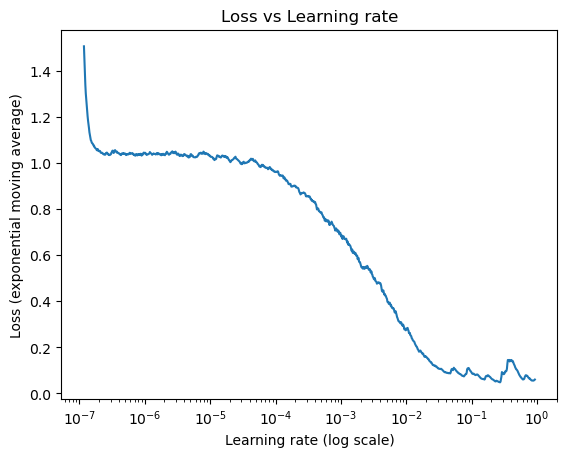

In [11]:
lrf.plot()


# Plot results

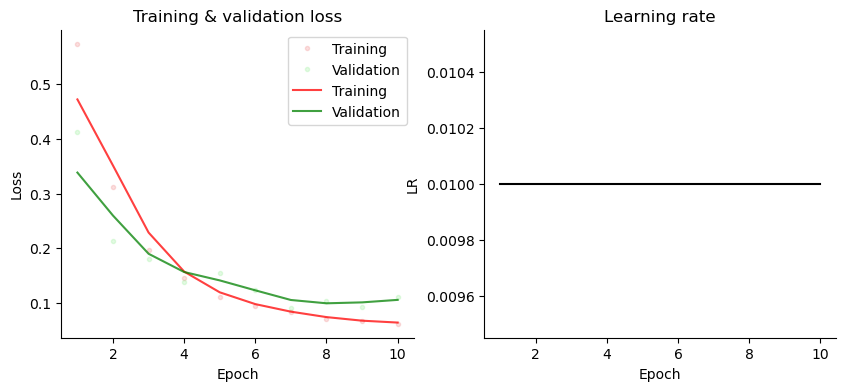

In [12]:
from visual import plot_training


fig = plot_training(
    training_losses,
    validation_losses,
    lr_rates,
    gaussian=True,
    sigma=1,
    figsize=(10, 4),
)

fig.savefig('test.png')